In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import imutils
from imutils import paths
import pylab as pl
import numpy as np
import random
import cv2
import os

In [4]:
from lenet import LeNet

---

To start with we need to **train** our machine learning model.

First tell the code where the data are:

In [5]:
dataset1 = '../../santa/'
dataset2 = '../../notsanta/'

Then specify a filename for where we're going to store the trained machine learning model:

In [6]:
modelname = './santa_model'

Next define parameters to initialize the number of epochs to train for, the initial learning rate, and the batch size:

In [7]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32

Let's make some empty lists to put our data and labels into:

In [8]:
data = []
labels = []

grab the paths to all the images and randomly shuffle them:

In [9]:
imagePaths = sorted(list(paths.list_images(dataset1))+list(paths.list_images(dataset2)))
random.seed(42)
random.shuffle(imagePaths)

Then we loop over the input imagepaths and put the image data into our data list and the corresponding label into a label list:

In [10]:
for imagePath in imagePaths:
    
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    label = 1 if label == "santa" else 0
    labels.append(label)

Then scale the raw pixel intensities to the range [0, 1] :

In [11]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing:

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

convert the labels from integers to vectors:

In [13]:
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

construct the image generator for data augmentation:

In [14]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

Initialize the machine learning model. 

Our images now have *height x width = 28 x 28* and they are RGB images which means that they have *3 channels*.

In [15]:
model = LeNet.build(width=28, height=28, chan=3, classes=2)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Then train the network:

In [16]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS, verbose=1)

Epoch 1/25
15/15 [==============================] - 2s 162ms/step - loss: 0.7054 - acc: 0.5563 - val_loss: 0.6661 - val_acc: 0.5828
Epoch 2/25
15/15 [==============================] - 1s 94ms/step - loss: 0.6616 - acc: 0.6086 - val_loss: 0.6028 - val_acc: 0.7485
Epoch 3/25
15/15 [==============================] - 2s 110ms/step - loss: 0.6214 - acc: 0.6400 - val_loss: 0.6229 - val_acc: 0.6074
Epoch 4/25
15/15 [==============================] - 2s 109ms/step - loss: 0.5904 - acc: 0.6755 - val_loss: 0.5744 - val_acc: 0.6380
Epoch 5/25
15/15 [==============================] - 1s 80ms/step - loss: 0.5296 - acc: 0.7320 - val_loss: 0.5012 - val_acc: 0.7301
Epoch 6/25
15/15 [==============================] - 1s 77ms/step - loss: 0.5218 - acc: 0.7385 - val_loss: 0.4574 - val_acc: 0.8282
Epoch 7/25
15/15 [==============================] - 1s 75ms/step - loss: 0.5078 - acc: 0.7699 - val_loss: 0.5212 - val_acc: 0.7362
Epoch 8/25
15/15 [==============================] - 1s 75ms/step - loss: 0.4818 

To save us re-training the network every time we can save the model:

In [17]:
model.save(modelname)

Let's plot the training loss and accuracy:

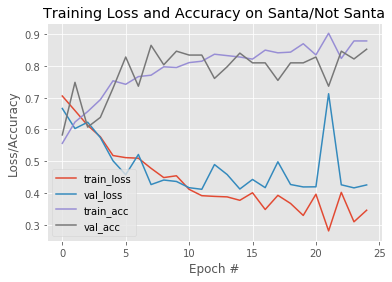

In [18]:
pl.style.use("ggplot")
pl.figure()
N = EPOCHS
pl.plot(np.arange(0, N), H.history["loss"], label="train_loss")
pl.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
pl.plot(np.arange(0, N), H.history["acc"], label="train_acc")
pl.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
pl.title("Training Loss and Accuracy on Santa/Not Santa")
pl.xlabel("Epoch #")
pl.ylabel("Loss/Accuracy")
pl.legend(loc="lower left")
pl.savefig("output.png")

---

Now we have a trained machine learning model we can **test** our classifier.

We need to pick a test image:

In [ ]:
testimage="../../santa/00000171.jpg"

In [ ]:
# pre-process the image for classification
image = cv2.imread(testimage)
orig = image.copy()
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [ ]:
(notSanta, santa) = model.predict(image)[0]

In [ ]:
label = "Santa" if santa > notSanta else "Not Santa"
proba = santa if santa > notSanta else notSanta
label = "{}: {:.2f}%".format(label, proba * 100)

In [ ]:
output = imutils.resize(orig, width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

array([[[249, 190, 154],
        [252, 202, 162],
        [254, 216, 175],
        ...,
        [255, 255, 246],
        [255, 255, 245],
        [255, 255, 245]],

       [[250, 209, 165],
        [249, 203, 156],
        [254, 220, 184],
        ...,
        [255, 255, 248],
        [255, 255, 247],
        [255, 255, 245]],

       [[232, 182, 138],
        [241, 188, 145],
        [238, 177, 145],
        ...,
        [255, 255, 245],
        [255, 255, 245],
        [255, 255, 245]],

       ...,

       [[255, 218, 179],
        [255, 218, 181],
        [254, 217, 179],
        ...,
        [254, 229, 204],
        [255, 229, 203],
        [254, 227, 201]],

       [[255, 216, 177],
        [254, 216, 177],
        [254, 214, 177],
        ...,
        [254, 228, 202],
        [255, 227, 201],
        [255, 226, 200]],

       [[254, 213, 174],
        [255, 212, 171],
        [254, 213, 173],
        ...,
        [255, 227, 199],
        [255, 225, 200],
        [255, 225, 200]]

In [ ]:
cv2.imshow("Output", output)
cv2.waitKey(0)